# Module 2.2 — Visualize Quantum Measurements

This notebook covers three topics aligned with IBM’s documentation and your Study Guide Section 2:

0. **Classical Feedforward & Control Flow** — with circuit plots and matching code  
1. **`plot_histogram`** — including plotting multiple histograms on the same figure  
2. **`plot_gate_map`** — options and examples

> Docs: Classical feedforward & control flow — https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow

In [1]:
# Minimal imports used throughout this notebook.
# Note: Designed for Qiskit v2.x (2.2.x). Some imports include fallbacks for older/newer layouts.
from typing import Dict, Any
import numpy as np

# Core Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# Visualization
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_gate_map

# Try to get a fake backend for plot_gate_map examples (no credentials required).
_fake_backend = None
try:
    from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
    _fake_backend = FakeSherbrooke()
except Exception:
    try:
        from qiskit.providers.fake_provider import FakeSherbrooke  # older layout
        _fake_backend = FakeSherbrooke()
    except Exception:
        _fake_backend = None

print("Fake backend for gate map:", type(_fake_backend).__name__ if _fake_backend else None)

Fake backend for gate map: FakeSherbrooke


## 0) Classical Feedforward & Control Flow — with circuit plots

This section demonstrates two approaches:
- **Conditional instructions (`c_if`)** — classical conditions that guard an operation based on a classical bit/register value.
- **Structured control flow (`if_test`)** — dynamic circuits that branch on measurement outcomes (requires dynamic-circuit support).

### 0A) Classical feedforward in Qiskit v2.x — use `if_test` (not `c_if`)
**Note:** `c_if(...)` is **not supported** in Qiskit v2.2.1 (it was removed in v2.x).  
Use structured control flow via `QuantumCircuit.if_test(...)` for feed-forward.

**How this works:**  
1. We measure a qubit into a classical bit.  
2. We open an `if_test((cbit, value)):` block that **conditionally** applies gates based on that classical result.  
3. Inside the block, the `X` gate is applied **only** on shots where the measured classical bit equals `1`.  
This is dynamic, shot-by-shot behavior consistent with OpenQASM-3-style control flow in Qiskit v2.x.


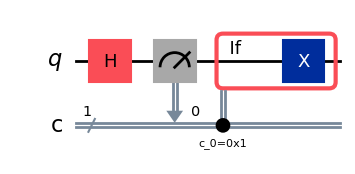

In [3]:
# 0A) Classical feedforward using c_if (portable across many versions)
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# One-qubit, one-classical-bit circuit
q = QuantumRegister(1, "q")
c = ClassicalRegister(1, "c")
qc = QuantumCircuit(q, c)

# Prepare superposition, then measure into classical bit c[0]
qc.h(0)
qc.measure(0, 0)

# Qiskit v2.x dynamic feed-forward: conditionally apply X if the measured bit equals 1
with qc.if_test((c[0], 1)):
    qc.x(0)

# Visualize
qc.draw('mpl')


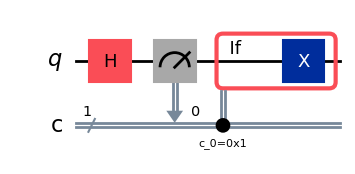

In [4]:
# 0B) Dynamic control flow using if_test (context manager style)
# This requires support in your Qiskit version/backends.
# If not supported in your local version, the 'with qc.if_test(...)' may raise.
q = QuantumRegister(1, "q")
c = ClassicalRegister(1, "c")
qd = QuantumCircuit(q, c)

qd.h(0)
qd.measure(0, 0)

try:
    # Branch: if measurement == 1, apply X; else do nothing
    with qd.if_test((c[0], 1)):
        qd.x(0)
    display(qd.draw('mpl'))
except Exception as e:
    print("if_test not available in this environment/Qiskit version:", e)
    display(qd.draw('mpl'))
qd

## 1) `plot_histogram` — including two histograms on the same plot

`plot_histogram` accepts either:
- a single **counts dict** (e.g., `{'00': 517, '11': 507}`), or
- a **list of counts dicts** to overlay multiple histograms.

Below we create two mock results and plot them both.

In [ ]:
# Mock counts for demonstration (these mirror what you might get from a Sampler or legacy Result.get_counts())
counts_a = {'00': 512, '11': 488}
counts_b = {'00': 400, '01': 100, '10': 120, '11': 380}

# A single histogram
fig1 = plot_histogram(counts_a, title="Single result")
display(fig1)

# Two histograms on the same axes
fig2 = plot_histogram([counts_a, counts_b], title="Overlay two results", legend=["Run A", "Run B"])
display(fig2)

## 2) `plot_gate_map` — options and examples

`plot_gate_map` shows the device’s qubits and connectivity. It can accept a backend (recommended) or a custom coupling map.
Common options include:
- `figsize=(w, h)` to resize,
- `qubit_size`, `line_width`, `font_size` to tweak appearance,
- `qubit_color`, `line_color` to customize colors,
- `label_qubits=True` to label nodes.

We’ll use a **fake backend** so this runs without account credentials.

In [ ]:
if _fake_backend is None:
    print("No fake backend available in this environment; showing a minimal example with a custom coupling map.")
    from qiskit.transpiler import CouplingMap
    cmap = CouplingMap([[0,1],[1,2],[2,3],[3,4]])
    fig = plot_gate_map(coupling_map=cmap, figsize=(5,5), label_qubits=True)
    display(fig)
else:
    # Example 1: basic plot
    fig_basic = plot_gate_map(_fake_backend, figsize=(6,6), label_qubits=True)
    display(fig_basic)

    # Example 2: tweak a few options
    fig_tweaked = plot_gate_map(
        _fake_backend,
        figsize=(6,6),
        label_qubits=True,
        qubit_size=12,
        line_width=1.5,
        font_size=8
    )
    display(fig_tweaked)

---

# Practice MCQs (Exam-style)

For each section above, you’ll see two patterns:  
**(A)** “Given code, what’s the most likely output?” and **(B)** “Which snippet is an invalid input?”  
Answers include explanations.

## MCQs — Section 0: Classical Feedforward & Control Flow

**Q0.1 — Output identification**  
Given:
```python
qc = QuantumCircuit(1, 1)
qc.h(0); qc.measure(0, 0)
qc.x(0).c_if(qc.clbits[0], 1)
```
Which is the most likely **behavior** of the circuit?
A. `X` is always applied.  
B. `X` is applied **only** when the measured bit is `1`.  
C. `X` is applied only when the measured bit is `0`.  
D. `X` is never applied.

<details><summary><strong>Answer</strong></summary>
B. The `.c_if(..., 1)` condition guards the `X` so it fires only if the classical bit equals 1.  
A is wrong (not always); C is the opposite condition; D is wrong (it does apply sometimes).
</details>

**Q0.2 — Invalid input**  
Which snippet is **invalid** for building an `if_test` branch?  
A. `with qc.if_test((c[0], 1)): qc.x(0)`  
B. `with qc.if_test((c[0], 2)): qc.x(0)`  
C. `with qc.if_test((c[0], 0)): qc.h(0)`  
D. `with qc.if_test((c[0], 1)): pass`

<details><summary><strong>Answer</strong></summary>
B. Classical bits store 0/1; checking equality with value `2` is invalid.  
A and C are valid 1-bit conditions; D is syntactically odd but forms an empty branch.
</details>

## MCQs — Section 1: plot_histogram

**Q1.1 — Output identification**  
Given:
```python
counts_a = {'00': 600, '11': 424}
counts_b = {'00': 420, '01': 100, '10': 120, '11': 384}
fig = plot_histogram([counts_a, counts_b], legend=['A','B'])
```
What appears on the figure?
A. Two overlaid histograms sharing the same x-axis (bitstrings), with legend entries **A** and **B**.  
B. A single histogram of the **sum** of the two dicts.  
C. A pie chart of bitstring probabilities for run A.  
D. An error, because `plot_histogram` does not accept lists.

<details><summary><strong>Answer</strong></summary>
A. Passing a list overlays multiple histograms with a shared x-axis.  
B is wrong (no implicit sum); C is a different plot type; D is false (lists are allowed).
</details>

**Q1.2 — Invalid input**  
Which call is invalid?
A. `plot_histogram({'0': 5, '1': 7})`  
B. `plot_histogram([{'0': 5}, {'1': 7}], legend=['A','B'])`  
C. `plot_histogram({'0': 5, '2': 7})`  
D. `plot_histogram([{'00': 1}], legend=None)`

<details><summary><strong>Answer</strong></summary>
C. Bitstrings must be composed of 0/1 characters per qubit; `'2'` is not a valid bitstring key.  
A is fine (single dict). B is fine (two dicts with legend). D is fine (legend optional).
</details>

## MCQs — Section 2: plot_gate_map

**Q2.1 — Output identification**  
Given a backend with labeled qubits and coupling map, calling:
```python
plot_gate_map(backend, label_qubits=True, figsize=(6,6))
```
What is plotted?
A. A scatter of random points.  
B. A diagram of qubit nodes with labels and connecting edges (device topology).  
C. A histogram of backend readout errors.  
D. A Bloch sphere of qubit 0.

<details><summary><strong>Answer</strong></summary>
B. `plot_gate_map` renders device topology (nodes and couplings). A, C, D are unrelated.
</details>

**Q2.2 — Invalid input**  
Which argument set is invalid (typical behavior)?
A. `plot_gate_map(backend=None, coupling_map=[[0,1],[1,2]])`  
B. `plot_gate_map(backend, label_qubits=True, qubit_size=12)`  
C. `plot_gate_map(coupling_map=[[0, 'a']])`  
D. `plot_gate_map(backend, figsize=(5,5))`

<details><summary><strong>Answer</strong></summary>
C. Coupling map edges must refer to **integer** qubit indices; `'a'` is invalid.  
A, B, D are acceptable patterns depending on version (A uses a custom coupling map).
</details>